#### Import Libraries

In [120]:
import numpy as np
from skimage import feature, color, util, io
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.nn.functional import one_hot
import cv2
import mediapipe as mp


#### Showcase pose estimation

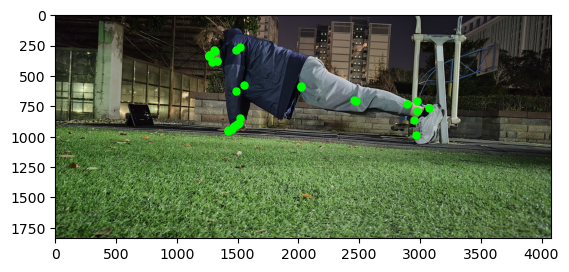

In [121]:
import cv2
import mediapipe as mp

path = '../pushupcollection/'

mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

image = cv2.imread(path+"pushup/P_20230306_225849.jpg")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = pose.process(image)

if not results.pose_landmarks:
    image = cv2.convertScaleAbs(image, alpha=2, beta=0)
    results = pose.process(image)
    
if results.pose_landmarks:
    # Create a new figure and axis for the image
    fig, ax = plt.subplots()
    ax.imshow(image)
    
    # Loop through the pose landmarks
    for landmark in results.pose_landmarks.landmark:
        # Get the x, y coordinates of the landmark (scaled to the size of the image)
        x = landmark.x * image.shape[1]
        y = landmark.y * image.shape[0]

        # Plot a circle at the landmark position
        ax.plot(x, y, 'o', color='lime', markersize=5)

    # Show the image with the landmarks plotted
    plt.show()

#### Define folder reading function

In [122]:
def readFolder(path, bodyPoints, startIndex, pose):
    
    for i, f in enumerate(os.listdir(path)):
        image = cv2.imread(path+f)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        results = pose.process(image)

        if not results.pose_landmarks:
            image = cv2.convertScaleAbs(image, alpha=2, beta=0)
            results = pose.process(image)
            
        if results.pose_landmarks:
            # Loop through the pose landmarks
            for j, landmark in enumerate(results.pose_landmarks.landmark):
                # Get the x, y coordinates of the landmark (scaled to the size of the image)
                x = landmark.x
                y = landmark.y
                
                bodyPoints[startIndex+i*2][j*2] = x
                bodyPoints[startIndex+i*2][j*2+1] = y
                
                # data augmentation
                # flip along x axis 
                bodyPoints[startIndex+i*2+1][j*2] = 1 - x
                bodyPoints[startIndex+i*2+1][j*2+1] = y
            #print(bodyPoints)
        else:
            print("bruh") 

    return bodyPoints

#### Create labels; get images and extact their features

In [123]:

n_images = 32
n_bodyPoints = 33

bodyPoints = np.zeros((n_images*2, n_bodyPoints*2))
y = np.zeros((n_images*2,))
y[n_images:n_images*2] += 1 

mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

path = '../pushupcollection/pushdown/'

bodyPoints = readFolder(path, bodyPoints, 0, pose)

path = '../pushupcollection/pushup/'

bodyPoints = readFolder(path, bodyPoints, n_images, pose)
            

### MAIN

In [135]:
import sys
sys.path.insert(1, '/media/commlab/TenTB/home/dmytro/AI_HW#1/')
%run ../heatmap.py
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

k = 5  # number of folds
neighborN = 10 # Choose the value of k

x = bodyPoints

cm_total = np.zeros((2, 2))
avg_acc = 0
avg_precision = 0
avg_recall = 0
avg_f1 = 0

# create a KFold object
kf = KFold(n_splits=k, shuffle=True)

# loop over the folds
i = 1
for train_index, test_index in kf.split(x):

    # split the data into training and test sets
    x_train, y_train = x[train_index], y[train_index]
    x_test, y_test = x[test_index], y[test_index]

    # Create a kNN classifier object
    knn = KNeighborsClassifier(n_neighbors=neighborN)

    # Train the classifier on your data
    knn.fit(x_train, y_train)

    y_pred = knn.predict(x_test)

    cm = confusion_matrix(y_test, y_pred, labels = [0, 1])

    cm_total = cm_total + cm
    # Evaluate the performance of the classifier
    avg_acc += accuracy_score(y_test, y_pred)
    avg_precision += precision_score(y_test, y_pred)
    avg_recall += recall_score(y_test, y_pred)
    avg_f1 += f1_score(y_test, y_pred)

print(f"Accuracy: {avg_acc/k:.2f}")
print(f"Precision: {avg_precision/k:.2f}")
print(f"Recall: {avg_recall/k:.2f}")
print(f"F1-Score: {avg_f1/k:.2f}")

grid_labels = ['down', 'up']
# compute the sum of each row
row_sums = cm_total.sum(axis=1)
cm_normalized = cm_total / row_sums[:, np.newaxis]
im, cbar = heatmap(cm_normalized, grid_labels, grid_labels)
annotate_heatmap(im)
plt.savefig("confusionMatrix_k_10.png")
plt.close()

Accuracy: 0.74
Precision: 0.95
Recall: 0.51
F1-Score: 0.63


<b>k = 1 </b> <br>
Accuracy: 0.94 <br>
Precision: 0.94 <br>
Recall: 0.94 <br>
F1-Score: 0.93

<b>k = 3 </b> <br>
Accuracy: 0.91 <br>
Precision: 0.95 <br>
Recall: 0.84 <br>
F1-Score: 0.89

<b>k = 5 </b> <br>
Accuracy: 0.86 <br>
Precision: 0.96 <br>
Recall: 0.77 <br>
F1-Score: 0.85

<b>k = 10 </b> <br>
Accuracy: 0.74 <br>
Precision: 0.95 <br>
Recall: 0.51 <br>
F1-Score: 0.63

In [48]:
if torch.cuda.is_available():
    print(f'{torch.cuda.device_count()} GPU(s) are available!')
    for i in range(torch.cuda.device_count()):
        print(f'GPU {i}: {torch.cuda.get_device_name(i)}')
        print(f'\tCompute capability: {torch.cuda.get_device_capability(i)}')
        print(f'\tMemory: {torch.cuda.get_device_properties(i).total_memory / 1024 ** 2:.2f} MB')
else:
    print('CUDA is not available.')


2 GPU(s) are available!
GPU 0: NVIDIA GeForce RTX 2080 Ti
	Compute capability: (7, 5)
	Memory: 11019.56 MB
GPU 1: NVIDIA GeForce RTX 2080 Ti
	Compute capability: (7, 5)
	Memory: 11018.25 MB
